In [2]:
import numpy as np
import scipy.stats
from sklearn.model_selection import train_test_split, GroupShuffleSplit
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import glm_class as glm
%matplotlib inline

In [3]:

# Check version and eager execution state
print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

# Get available devices
devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.18.0
keras version 3.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [4]:
def generate_dataset(model_type = 'gaussian', n_samples = 1000, n_features = 50, n_responses = 100, 
                     fraction_observed_features = 0.8, clip_Y_value = 10000., plot_mean_responses = True):
    # Generate X
    X_full = np.random.normal(size = (n_samples, n_features)) 

    # Create some collinearity in X
    X_full[:,n_features//10:2*n_features//10] = X_full[:,:n_features//10] + np.random.normal(scale = 0.5, size = (n_samples, n_features//10))

    # Z-score predictors
    X_full = scipy.stats.zscore(X_full, axis = 0)

    # Create weights and biases
    w_true = np.random.normal(scale = 0.25, size = (n_features, n_responses))
    w0_true = np.random.normal(loc = 1.2, scale = 0.25, size = n_responses)

    # Generate Y
    if model_type == 'gaussian':
        Y = np.dot(X_full, w_true) + w0_true + np.random.normal(scale = 0.25, size = (n_samples, n_responses))  
    elif model_type == 'poisson':
        Y = scipy.stats.poisson.rvs(np.exp(np.dot(X_full, w_true) + w0_true)) 

    # Clip Y
    Y = np.minimum(Y, clip_Y_value)
    
    # Plot mean values for all responses
    if plot_mean_responses == True:
        plt.hist(Y.mean(axis = 0), bins = 20)
        plt.title('Distribution of mean Y')
        plt.xlabel('Mean Y')
        plt.ylabel('Count')

    # Remove some features from X as "unobserved" (so the mean fraction deviance explained should <= fraction_observed_predictor)
    n_observed_features = int(fraction_observed_features*n_features)
    X = X_full[:,:n_observed_features]

    return X, Y, w_true[:n_observed_features,:], w0_true

Shape of observed X = (5000, 160)
Shape of Y = (5000, 100)
Shape of true weights (observed part) = (160, 100)
Shape of true intercepts = (100,)


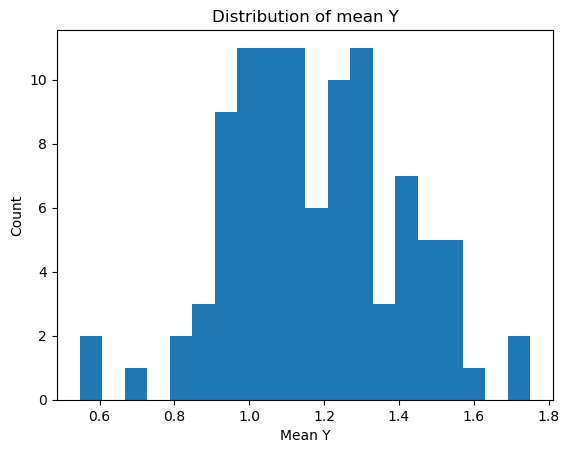

In [5]:
# Generate data with Gaussian model
X, Y, w_true, w0_true = generate_dataset(model_type = 'gaussian', n_samples = 5000, n_features = 200, n_responses = 100, 
                                         fraction_observed_features = 0.8, clip_Y_value = 10000., plot_mean_responses = True)

print('Shape of observed X =', X.shape)
print('Shape of Y =', Y.shape)
print('Shape of true weights (observed part) =', w_true.shape)
print('Shape of true intercepts =', w0_true.shape)
     

In [6]:

## Split data into train and test set
test_size = 0.3

# Split data randomly with train_test_split function from sklearn
X_train, X_test_val, Y_train, Y_test_val = train_test_split(X, Y, test_size = test_size, random_state = 42)

# Further split test_val data into two: for validation and test
n_val = X_test_val.shape[0]//2
X_val = X_test_val[:n_val,:]
Y_val = Y_test_val[:n_val,:]
X_test = X_test_val[n_val:,:]
Y_test = Y_test_val[n_val:,:]

In [ ]:

# Reset all keras states
tf.keras.backend.clear_session()

# Initialize GLM 
model = glm.GLM(activation = 'linear', loss_type = 'gaussian', 
                regularization = 'elastic_net', lambda_series = 10.0 ** np.linspace(3, -6, 10), l1_ratio = 0., smooth_strength = 0., 
                optimizer = 'adam', learning_rate = 1e-2, momentum = 0.5, 
                min_iter_per_lambda = 100, max_iter_per_lambda = 10**4, num_iter_check = 100, convergence_tol = 1e-6)

In [ ]:

# Fit the model to training data
model.fit(X_train, Y_train, verbose = True)